In [25]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
import matplotlib.patheffects as pe
from collections import defaultdict
from scipy.stats import median_abs_deviation as mad
from scipy import ndimage as ndi

# Parámetros de entrada 
BASE_DIR = "."                 # Carpeta donde están los archivos .dat (subcarpetas por ánodo)
TARGET_KV_FOR_COMPARISON = 30.0  # kV para la comparación entre ánodos (panel A)
N_CURVES_PER_ANODE = 5           # número de curvas (kV) a mostrar por ánodo en los waterfalls

# Mapeo de ánodo desde el encabezado
ANODE_MAP = {'molybdenum': 'Mo', 'rhodium': 'Rh', 'tungsten': 'W'}

# Líneas características aproximadas (keV) para anotar picos
# (En los datos: Mo y Rh -> serie K 17–23 keV; W -> serie L 8–11 keV) X-Ray Data Booklet del Lawrence Berkeley National Lab (LBNL
CHAR_LINES = {  
    "Mo": [("Kα", 17.48), ("Kβ", 19.61)],
    "Rh": [("Kα", 20.22), ("Kβ", 22.72)],
    "W" : [("Lα",  8.40), ("Lβ",  9.67), ("Lγ", 11.29)],
}

# Estilo base para gráficos "bonitos" y legibles
plt.rcParams.update({
    "figure.dpi": 160,
    "savefig.dpi": 300,
    "axes.titlesize": 12,
    "axes.labelsize": 11,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "legend.fontsize": 9,
    "axes.facecolor": "#FAFAFB", 
    "figure.facecolor": "white",
    "axes.edgecolor": "#666666",
    "grid.color": "#AAAAAA",
})


In [14]:
def anode_element(line: str):
    """
    Extrae el ánodo ('Mo', 'Rh', 'W') si la línea contiene 'anode: molybdenum|rhodium|tungsten'.
    Devuelve None si no se puede determinar.
    """
    s = line.strip().lower()
    if "anode:" not in s:
        return None
    val = s.split("anode:", 1)[1].strip()
    if not val:
        return None
    return ANODE_MAP.get(val.split()[0])  # primera palabra tras 'anode:'

def tube_kv(line: str):
    """
    Busca un número de kV en líneas que contengan 'kv' o 'tube voltage'.
    Acepta variantes como: 'tube voltage: 30 kV', '30 kV', 'tube voltage 25 kV'.
    Devuelve float(kV) o None.
    """
    s = line.strip().lower()
    if ("kv" not in s) and ("tube voltage" not in s):
        return None
    cleaned = s.replace("kv", " ").replace(":", " ")
    for tok in cleaned.split():
        try:
            val = float(tok)
            if 1.0 <= val <= 200.0:
                return val
        except ValueError:
            pass
    return None

def spectrum(filepath):
    """
    Lee un espectro ASCII (.dat) con dos columnas (E, F) y encabezado con 'anode:' y 'kV'.
    - E: energía (keV)   - F: fluencia normalizada (photons keV^-1 cm^-2)
    - kV: voltaje del tubo   - anode: material del ánodo ('Mo'|'Rh'|'W')
    Devuelve: E, F, kV, anode
    """
    energy, fluence = [], []
    kV, anode = None, None

    with open(filepath, 'r', encoding='utf-8', errors='ignore') as f:
        for line in f:
            s = line.strip()
            if not s:
                continue
            low = s.lower()
            is_header = s.startswith("#") or ("anode" in low) or ("kv" in low) or ("tube voltage" in low)
            if is_header:
                if anode is None:
                    anode = anode_element(s)
                if kV is None:
                    kV = tube_kv(s)
                continue
            # datos numéricos (dos columnas)
            parts = s.split()
            if len(parts) >= 2:
                try:
                    e = float(parts[0]); fval = float(parts[1])
                    energy.append(e); fluence.append(fval)
                except ValueError:
                    pass


    # Convertir a arrays y ordenar por energía
    E = np.asarray(energy, dtype=float)
    F = np.asarray(fluence, dtype=float)
    if E.size and np.any(np.diff(E) < 0):
        idx = np.sort(E); E, F = E[idx], F[idx]
    return E, F, kV, anode

def spectrum_files(base_dir):
    """
    Recorre recursivamente BASE_DIR y devuelve SOLO rutas .dat (lo pedido por el enunciado).
    """
    paths = []
    for root, _, files in os.walk(base_dir):
        for fn in files:
            if fn.lower().endswith(".dat"):   # << SOLO .dat
                paths.append(os.path.join(root, fn))
    return paths

def build_dataset(base_dir):
    """
    Construye un diccionario: data[anodo][kV] = (E, F)
    - Lee todos los .dat válidos.
    - Conserva un espectro por (ánodo, kV).
    - Ordena las claves kV para cada ánodo.
    """
    data = {"Mo": {}, "Rh": {}, "W": {}}
    for fp in spectrum_files(base_dir):
        try:
            E, F, kv, an = spectrum(fp)
        except Exception:
            continue
        if an in data and kv is not None and E.size > 0:
            if kv not in data[an]:
                data[an][kv] = (E, F)

    for an in data:
        data[an] = dict(sorted(data[an].items(), key=lambda x: x[0]))
    return data



In [15]:
def pick_nearest(values, target):
    """Devuelve el valor de 'values' más cercano a 'target' (kV=30)."""
    if not values:
        return None
    return min(values, key=lambda v: abs(v - target))

def pick_kv_subset(sorted_list, n=5):
    """
    Selecciona n valores espaciados a lo largo de la lista ordenada de kV.
    Aquí usamos n=5 para legibilidad.
    """
    if not sorted_list:
        return []
    if len(sorted_list) <= n:
        return sorted_list
    idx = np.linspace(0, len(sorted_list) - 1, n).round().astype(int)
    return [sorted_list[i] for i in idx]

def nice_axis(ax):
    """Etiquetas comunes y límites (deja que matplotlib auto-ajuste Y)."""
    ax.set_xlabel("Energía [keV]")
    ax.set_ylabel(r"Conteo de Fotones [$\mathrm{photons\;keV^{-1}\;cm^{-2}}$]")

def characteristic_lines(ax, anode, e_min, e_max):
    """
    Dibuja líneas verticales y etiquetas de energías características
    (Kα/Kβ o Lα/Lβ/Lγ) si caen dentro del rango del subplot).
    """
    for label, e0 in CHAR_LINES.get(anode, []):
        if e_min <= e0 <= e_max:
            ax.axvline(e0, ls=":", lw=1.1, color="#555555", alpha=0.8)
            ax.text(e0, ax.get_ylim()[1]*0.92, label, rotation=90,
                    va="top", ha="center", fontsize=8, color="#444444")

def beautify(ax):
    """
    Toques estéticos: rejilla suave, ticks menores, spines discretas.
    """
    ax.grid(True, which="major", alpha=0.25, linewidth=0.9)
    ax.grid(True, which="minor", alpha=0.12, linewidth=0.6)
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    for sp in ax.spines.values():
        sp.set_alpha(0.4)

def color_cmap(cmap_name, n):
    """
    Genera una lista de n colores uniformemente espaciados de un colormap para mejorar estética.
    """
    cmap = plt.get_cmap(cmap_name)
    if n == 1:
        return [cmap(0.6)]
    return [cmap(i/(n-1)) for i in range(n)]

def plot_waterfall(ax, anode, n_curves, data, cmap_name="viridis"):
    """
    Dibuja curvas desplazadas verticalmente (waterfall) para un ánodo.
    - Muestra el impacto del kV (variable) manteniendo energía en x y conteo en y.
    - Se anotan líneas características y la línea de corte E=kV.
    - Colores de colormap + rellenos suaves.
    """

    kvs = list(data[anode].keys())
    sel = pick_kv_subset(kvs, n_curves)
    colors = color_cmap(cmap_name, len(sel))
    offset = 0.0
    d_off  = 0.20 * max(1.0, n_curves / 5.0)  # separación entre curvas (ajustable)
    y_max  = 0.0
    e_min, e_max = float("inf"), -float("inf")

    for (kv, color) in zip(sel, colors):
        E, F = data[anode][kv]
        # Curva principal (mejor legibilidad)
        line = ax.plot(E, F + offset, lw=2.2, color=color, alpha=0.95,
                       path_effects=[pe.Stroke(linewidth=3.8, foreground="white", alpha=0.9),
                                     pe.Normal()])[0]
        # Relleno suave para reforzar la forma
        ax.fill_between(E, offset, F + offset, color=color, alpha=0.10, linewidth=0)

        # Línea vertical en E≈kV (corte del continuo por bremsstrahlung)
        ax.axvline(kv, ls="--", lw=1.1, color=color, alpha=0.55, ymin=0.0, ymax=0.95)
        ax.text(kv, (F+offset).max()*1.02 if len(F) else offset, f"{kv:.0f} kV",
                color=color, fontsize=8, ha="center", va="bottom")

        # Actualizar rangos y desplazamiento
        if len(F): y_max = max(y_max, (F + offset).max())
        if len(E): e_min = min(e_min, E.min()); e_max = max(e_max, E.max())
        offset += d_off

    ax.set_ylim(0, y_max * 1.08 if y_max > 0 else 1.0)
    if e_min < e_max:
        characteristic_lines(ax, anode, e_min, e_max)

    # Axis y estética
    ax.set_yticks([])  # la escala absoluta en Y no es el foco en la vista 'waterfall'
    nice_axis(ax); beautify(ax)

    # Leyenda y aclaración sobre el desplazamiento artificial
    ax.legend([f"{kv:.0f} kV" for kv in sel], ncol=min(5, len(sel)),
              frameon=False, loc="upper right", title="Voltajes")
    ax.text(0.01, -0.18,
            "Desplazamiento vertical artificial para claridad (no escala absoluta)",
            transform=ax.transAxes, ha="left", va="top", fontsize=9, alpha=0.85)


In [16]:
data = build_dataset(BASE_DIR)

# Verificación rápida: debe existir al menos un ánodo con datos
available = [an for an in data if data[an]]

# Para el panel (A), elegimos el kV más cercano a 30 kV por cada ánodo disponible
kv_choice = {an: pick_nearest(list(data[an].keys()), TARGET_KV_FOR_COMPARISON)
             for an in ["Mo", "Rh", "W"] if data[an]}

# (Opcional) mini-resumen por consola para trazabilidad
for an in ["Mo","Rh","W"]:
    if data[an]:
        ks = list(data[an].keys())
        print(f"{an}: {len(ks)} espectros, rango kV = [{ks[0]:.0f},{ks[-1]:.0f}] -> kV comparación: {kv_choice.get(an)}")


Mo: 41 espectros, rango kV = [10,50] -> kV comparación: 30.0
Rh: 41 espectros, rango kV = [10,50] -> kV comparación: 30.0
W: 41 espectros, rango kV = [10,50] -> kV comparación: 30.0


Figura guardada como 1.pdf


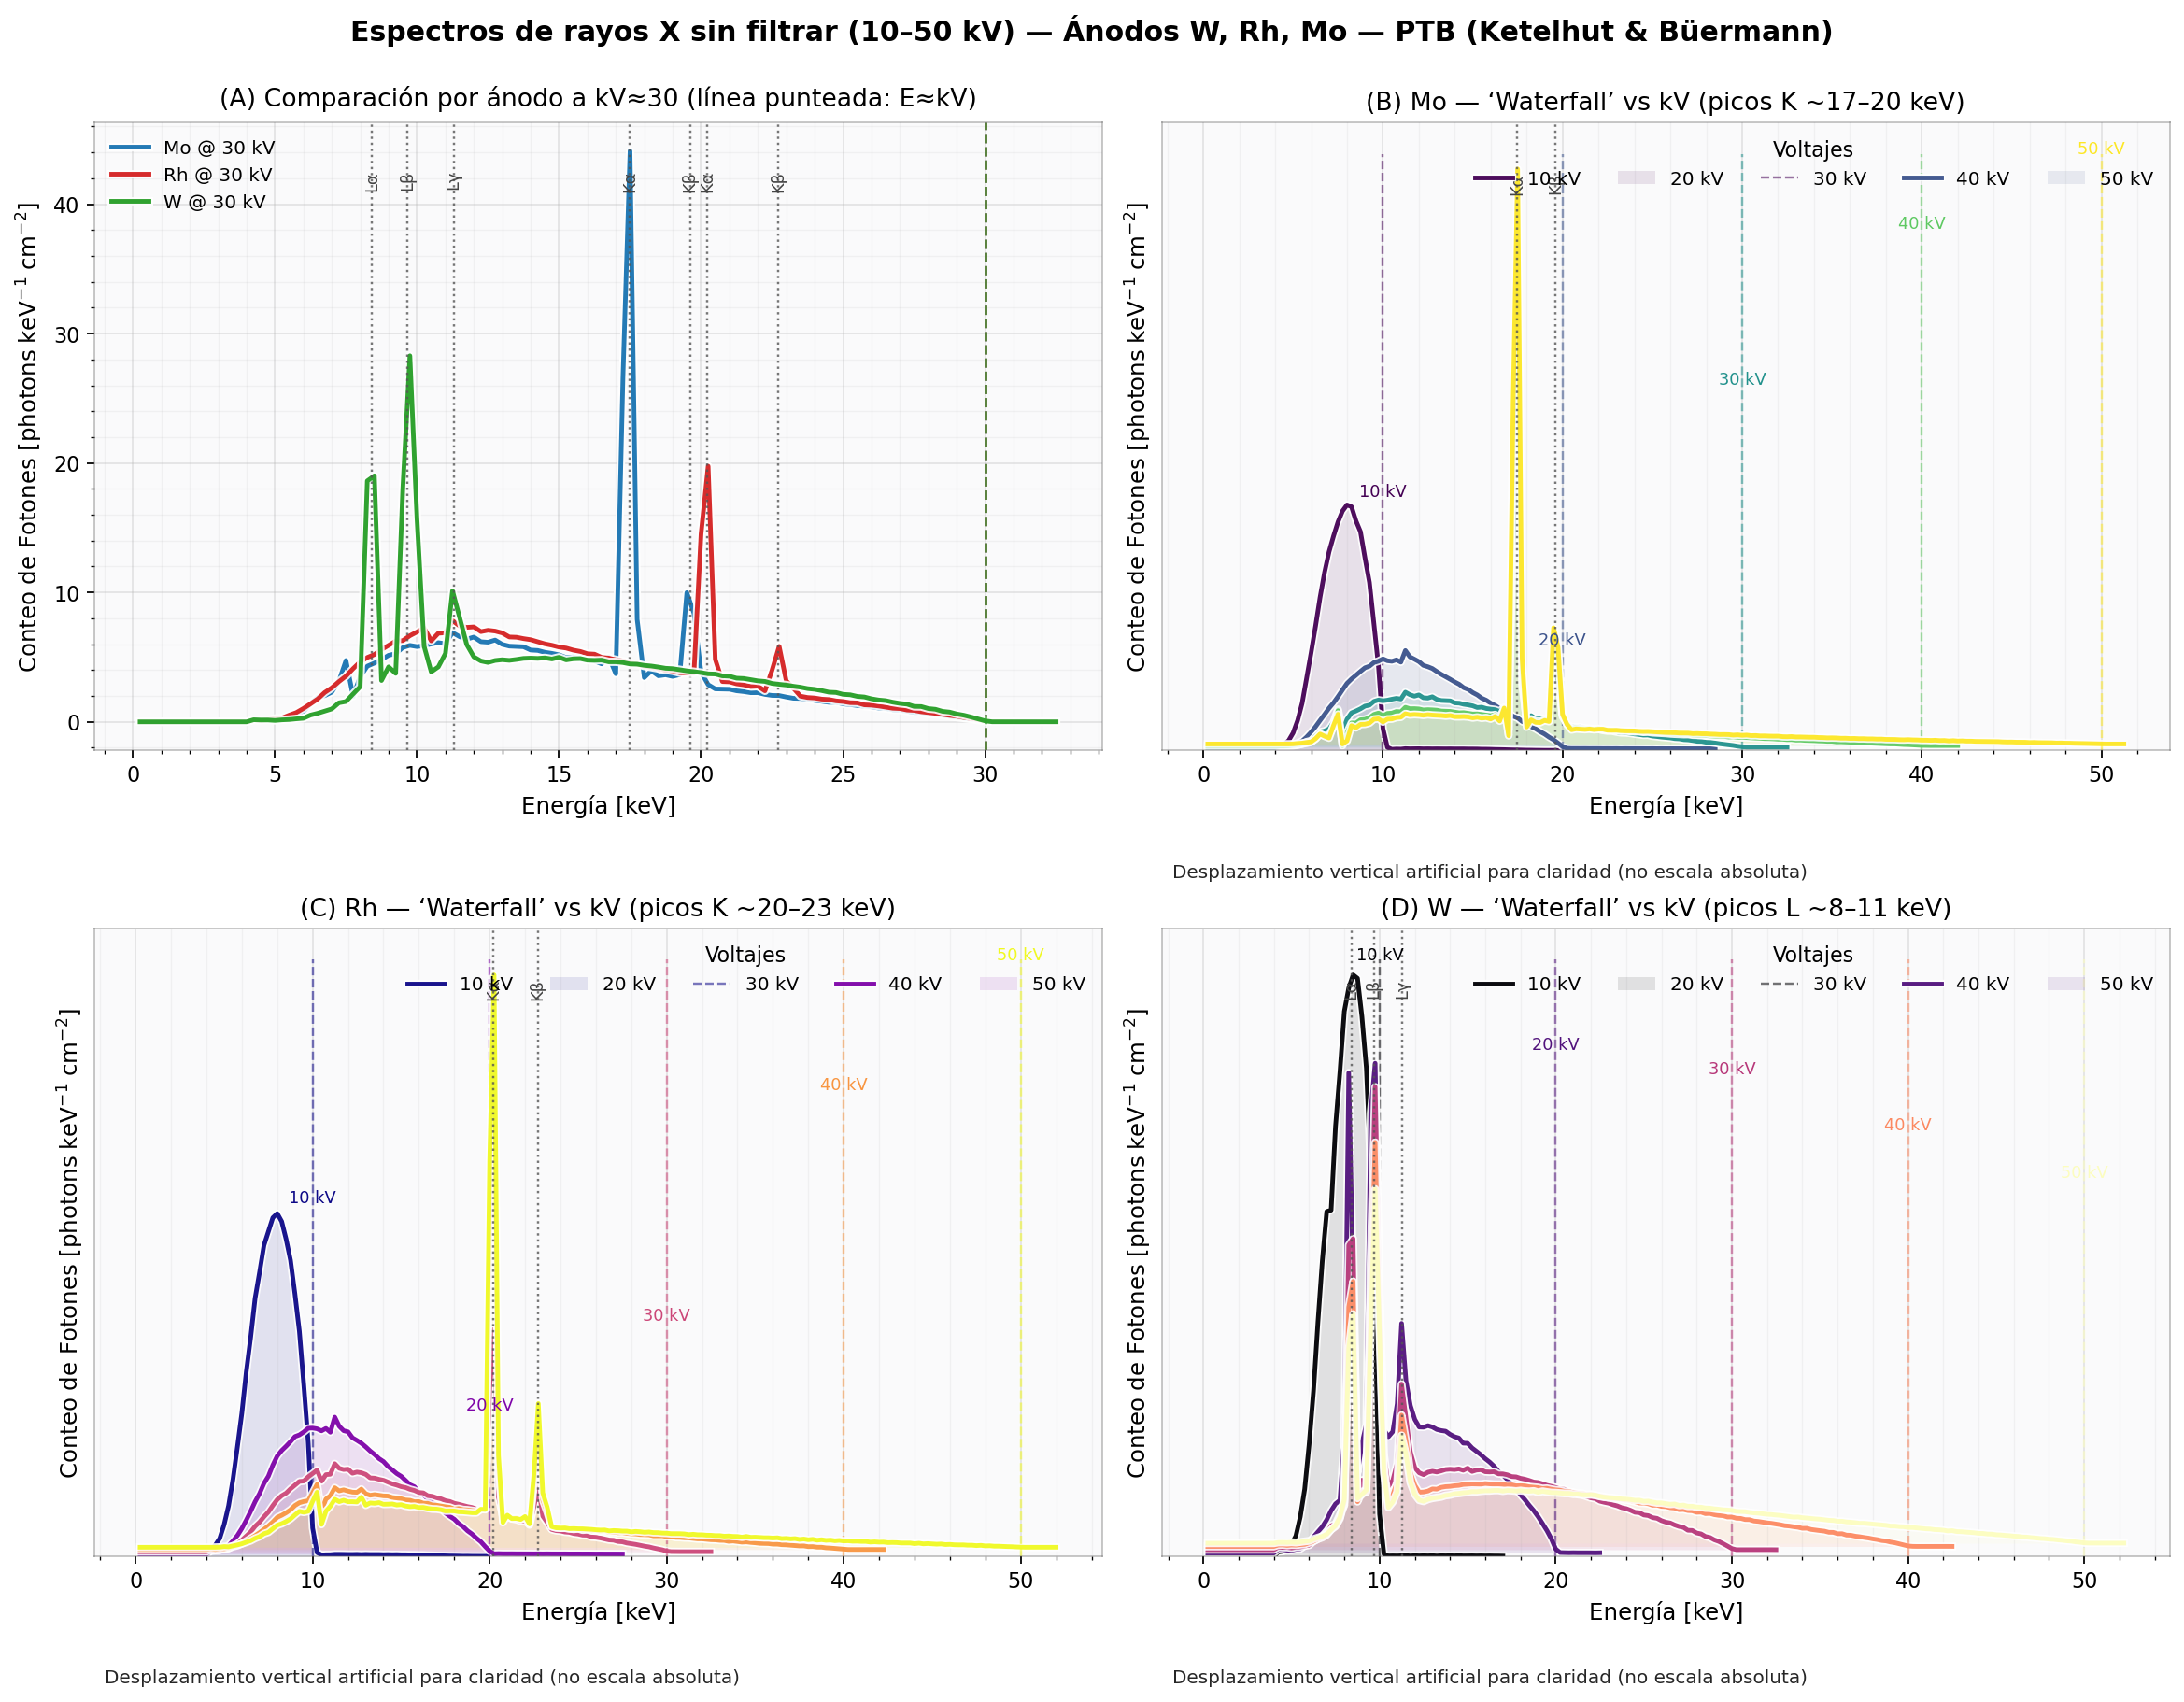

In [18]:
# 1
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
import matplotlib.patheffects as pe



#  FIGURA EN MOSAICO 2×2 ---
fig = plt.figure(constrained_layout=True, figsize=(14.5, 10.8))
axd = fig.subplot_mosaic([["A", "B"],
                          ["C", "D"]])

# (A) Comparación por ánodo a ~30 kV (impacto del material del ánodo)
axA = axd["A"]
for an, color in zip(["Mo", "Rh", "W"], ["#1f77b4", "#d62728", "#2ca02c"]):
    if an in kv_choice and kv_choice[an] is not None and kv_choice[an] in data[an]:
        E, F = data[an][kv_choice[an]]
        axA.plot(E, F, lw=2.2, color=color, alpha=0.98,
                 path_effects=[pe.Stroke(linewidth=4.0, foreground="white", alpha=0.9),
                               pe.Normal()],
                 label=f"{an} @ {kv_choice[an]:.0f} kV")
        axA.axvline(kv_choice[an], ls="--", lw=1.2, color=color, alpha=0.75)  # E≈kV
        characteristic_lines(axA, an, E.min(), E.max())
axA.set_title("(A) Comparación por ánodo a kV≈30 (línea punteada: E≈kV)", pad=8)
nice_axis(axA); beautify(axA)
axA.legend(frameon=False, loc="upper left")

# (B) Waterfall — Mo (impacto del kV con 5 curvas representativas)
axB = axd["B"]
if data.get("Mo", {}):
    plot_waterfall(axB, "Mo", N_CURVES_PER_ANODE, data, cmap_name="viridis")
    axB.set_title("(B) Mo — ‘Waterfall’ vs kV (picos K ~17–20 keV)")

# (C) Waterfall — Rh
axC = axd["C"]
if data.get("Rh", {}):
    plot_waterfall(axC, "Rh", N_CURVES_PER_ANODE, data, cmap_name="plasma")
    axC.set_title("(C) Rh — ‘Waterfall’ vs kV (picos K ~20–23 keV)")

# (D) Waterfall — W
axD = axd["D"]
if data.get("W", {}):
    plot_waterfall(axD, "W", N_CURVES_PER_ANODE, data, cmap_name="magma")
    axD.set_title("(D) W — ‘Waterfall’ vs kV (picos L ~8–11 keV)")

# Título general arriba (separado del mosaico) y guardado como 1.pdf
title_txt = "Espectros de rayos X sin filtrar (10–50 kV) — Ánodos W, Rh, Mo — PTB (Ketelhut & Büermann)"
fig.suptitle(title_txt, y=1.04, fontsize=13.5, fontweight="semibold")
plt.savefig("1.pdf", bbox_inches="tight", pad_inches=0.1)
print("Figura guardada como 1.pdf")


**Figura 1 — Espectros de rayos X sin filtrar en calidad de mamografía (10–50 kV).**  
(A) **Comparación por ánodo** (W, Rh, Mo) a ~**30 kV**: se aprecia el impacto del **material del ánodo** sobre el espectro; la línea punteada marca **E≈kV** (corte del continuo por bremsstrahlung) y se anotan **líneas características** (K o L) cuando caen en el rango.  
(B) **Mo — “Waterfall” vs kV** (5 curvas esp





aciadas): muestra el efecto del **voltaje del tubo** sobre el espectro de Mo; se señalan picos **K** (~17–20 keV).  
(C) **Rh — “Waterfall” vs kV** (5 curvas): evolución con kV y picos **K** (~20–23 keV).  
(D) **W — “Waterfall” vs kV** (5 curvas): evolución con kV; en este rango sólo se excitan líneas **L** (~8–11 keV).  
Ejes: **energía** (keV) en x y **fluencia normalizada** (photons keV⁻¹ cm⁻²) en y. En los “waterfalls” las curvas se **desplazan verticalmente** solo para facilitar la comparación (no representa escala absoluta).


In [ ]:
# Utilidades punto 2

def _deriv_z(y):
    """
    Calcula un puntaje-z robusto de la derivada del espectro.
    Retorna: array de z-scores robustos (uno por segmento entre puntos).
    """
    d = np.diff(y)
    med = np.median(d)
    mad = np.median(np.abs(d - med)) + 1e-12
    z = (d - med) / (1.4826*mad + 1e-12)
    return z

def _mask_by_char_lines(E, anode, width=0.8):
    """
    Marca True en ventanas ±width alrededor de las líneas características del ánodo.
    Usa CHAR_LINES ya definido en la Celda 2.
    """
    mask = np.zeros_like(E, dtype=bool)
    for _, eline in CHAR_LINES.get(anode, []):
        mask |= (np.abs(E - eline) <= width)
    return mask

def _mask_by_derivative(E, F, z_thresh=6.0, min_sep=5):
    """
    Detecta picos por cambios bruscos (|z| > z_thresh) y agrupa índices cercanos.
    Expande 2–3 puntos a cada lado para cubrir todo el pico.
    """
    z = _deriv_z(F)
    cand = np.where(np.abs(z) > z_thresh)[0]
    groups = []
    for i in cand:
        if not groups or i - groups[-1][-1] > min_sep:
            groups.append([i])
        else:
            groups[-1].append(i)
    mask = np.zeros_like(F, dtype=bool)
    for g in groups:
        i0, i1 = g[0], g[-1] + 1
        i0 = max(0, i0 - 2); i1 = min(len(F), i1 + 3)
        mask[i0:i1] = True
    return mask

def remove_peaks(E, F, anode, kv, char_w=0.8, z_thresh=6.0):
    """
    Combina: (1) líneas características, (2) derivada, (3) corte > kv+0.5.
    Si enmascara >60% del espectro, relaja (solo líneas + corte por kV).
    Retorna: máscara booleana con True donde hay picos a eliminar.
    """
    mask = _mask_by_char_lines(E, anode, width=char_w) | _mask_by_derivative(E, F, z_thresh=z_thresh)
    if kv is not None:
        mask |= (E > kv + 0.5)
    if mask.mean() > 0.6:
        mask = _mask_by_char_lines(E, anode, width=char_w) | (E > (kv + 0.5 if kv else E.max()+1))
    return mask

def fit_continuum(E, F, mask, smooth_factor=0.002):
    """
    Ajusta continuo usando puntos sin picos (~mask).
    Preferencias: UnivariateSpline (suavizado) > PCHIP > interp lineal.
    Devuelve una función f(X) o None si no se pudo ajustar.
    """
    ok = ~mask
    x, y = E[ok], F[ok]
    m = np.isfinite(x) & np.isfinite(y)
    x, y = x[m], y[m]
    if len(x) < 8:
        return None
    if 'UnivariateSpline' in globals() and UnivariateSpline is not None:
        s = smooth_factor * len(x) * (np.max(y)-np.min(y))**2
        try:
            us = UnivariateSpline(x, y, s=s, k=3)
            return lambda X: np.clip(us(X), 0, np.inf)
        except Exception:
            pass
    if 'PchipInterpolator' in globals() and PchipInterpolator is not None:
        try:
            p = PchipInterpolator(x, y)
            return lambda X: np.clip(p(X), 0, np.inf)
        except Exception:
            pass
    return lambda X: np.interp(X, x, y, left=y[0], right=y[-1]).clip(0, np.inf)

def fwhm_from_curve(E_dense, Y_dense):
    """
    Calcula (y_max, e_max, FWHM) sobre una curva densa Y(E).
    Interpola cruces a media altura a izquierda y derecha.
    """
    i_max = int(np.argmax(Y_dense))
    y_max = float(Y_dense[i_max])
    if y_max <= 0:
        return np.nan, np.nan, np.nan
    half = 0.5 * y_max
    # izquierda
    iL = np.where(Y_dense[:i_max] <= half)[0]
    if len(iL) == 0: 
        eL = np.nan
    else:
        i1 = iL[-1]; i2 = i1 + 1
        if i2 <= i_max - 1:
            t = (half - Y_dense[i1]) / (Y_dense[i2] - Y_dense[i1] + 1e-12)
            eL = E_dense[i1] + t * (E_dense[i2] - E_dense[i1])
        else:
            eL = E_dense[i1]
    # derecha
    iR = np.where(Y_dense[i_max:] <= half)[0]
    if len(iR) == 0: 
        eR = np.nan
    else:
        i1 = i_max + iR[0] - 1; i2 = i1 + 1
        if i2 < len(E_dense):
            t = (half - Y_dense[i1]) / (Y_dense[i2] - Y_dense[i1] + 1e-12)
            eR = E_dense[i1] + t * (E_dense[i2] - E_dense[i1])
        else:
            eR = E_dense[i2 - 1]
    width = (eR - eL) if (np.isfinite(eL) and np.isfinite(eR)) else np.nan
    return y_max, float(E_dense[i_max]), width
def smooth_continuum_simple(E, F, anode, window_keV=1.0):
    """
    Estima un continuo suave con media móvil, evitando promediar exactamente en los picos:
    - Enmascara ±0.5 keV alrededor de cada línea característica del ánodo.
    - Interpola sobre esos huecos y aplica una ventana ~window_keV.
    """
    Fin = F.astype(float).copy()
    if anode in CHAR_LINES:
        for _, e0 in CHAR_LINES[anode]:
            m = np.abs(E - e0) <= 0.5
            Fin[m] = np.nan
    # Interpolación lineal donde hay NaN
    ok = ~np.isnan(Fin)
    if ok.sum() >= 2:
        Fin[~ok] = np.interp(E[~ok], E[ok], Fin[ok])
    else:
        Fin = F
    # Ventana en nº de bins
    step = E[1]-E[0] if len(E) > 1 else 0.25
    w = max(3, int(round(window_keV/step)))
    if w % 2 == 0: w += 1
    kernel = np.ones(w)/w
    cont = np.convolve(Fin, kernel, mode="same")
    cont = np.clip(cont, 0, None)
    return cont



def peak_mask_around_lines(E, R, anode,line_window=1.0, band_window=2.0, k_high=2.0, k_low=1.0):
    """
    Devuelve una máscara booleana con TODOS los bins que pertenecen a picos cercanos a cada línea característica del ánodo.
    """
    # Inicializa la máscara de salida (todo False).
    mask = np.zeros_like(R, dtype=bool)
    # Obtiene la lista de líneas del ánodo dado, si no hay, retorna máscara vacía.
    lines = CHAR_LINES.get(anode, [])
    if not lines:
        return mask
    # Recorre cada línea característica del ánodo.
    for _, e0 in lines:
        # Calcula índices de la banda y del núcleo usando searchsorted.
        # Banda: [e0 - band_window, e0 + band_window]
        i0 = np.searchsorted(E, e0 - band_window, side='left')
        i1 = np.searchsorted(E, e0 + band_window, side='right')
        # Núcleo: [e0 - line_window, e0 + line_window]
        j0 = np.searchsorted(E, e0 - line_window, side='left')
        j1 = np.searchsorted(E, e0 + line_window, side='right')
        # Si por cualquier razón los intervalos quedan vacíos o invertidos, salta.
        if i1 <= i0 or j1 <= j0:
            continue
        # Índices explícitos de banda y núcleo (segmentos contiguos).
        band_idx = np.arange(i0, i1)
        core_idx = np.arange(j0, j1)
        # Índices para estimar el fondo: banda EXCLUYENDO el núcleo cuando haya suficientes puntos.
        bg_idx = np.setdiff1d(band_idx, core_idx)
        bg = R[bg_idx] if bg_idx.size > 3 else R[i0:i1]
        # Estadísticos robustos del fondo: mediana y MAD (escalado normal).
        med = np.median(bg)
        scale = mad(bg, scale='normal', nan_policy='omit')
        # Salvaguardas por si MAD no es finito o es cero: usa std o un fallback proporcional.
        if not np.isfinite(scale) or scale == 0:
            s = np.nanstd(bg)
            scale = s if (np.isfinite(s) and s > 0) else 0.05 * max(np.nanmax(bg), 1e-6)
        # Umbrales alto (semillas) y bajo (crecimiento) basados en mediana+K*escala.
        thr_high = med + k_high * scale
        thr_low  = med + k_low  * scale
        # Extrae los valores del residuo dentro del núcleo.
        Rc = R[j0:j1]
        # Semillas: bins del núcleo que superan el umbral alto.
        seeds = Rc > thr_high
        # Si no hay semillas (caso borde), toma el máximo local del núcleo como única semilla.
        if not np.any(seeds):
            seeds = np.zeros_like(Rc, dtype=bool)
            seeds[int(np.nanargmax(Rc))] = True
        # Región de crecimiento: bins del núcleo por encima del umbral bajo.
        grow = Rc >= thr_low
        # Propaga las semillas dentro de la región permitida (grow).
        # Esto replica la expansión con while hacia izquierda/derecha,
        # deteniéndose automáticamente donde grow es False.
        keep = ndi.binary_propagation(seeds, mask=grow)
        # Marca en la máscara global los bins del núcleo que quedaron en el pico.
        mask[j0:j1][keep] = True
    # Devuelve la máscara final con todos los picos marcados.
    return mask


In [ ]:
#Punto 2

# 2.a 

#Construcción de la figura (tres subplots: Rh, Mo, W)
anodes_order = [a for a in ["Rh", "Mo", "W"] if data.get(a, {})]
n = len(anodes_order)
if n == 0:
    fig, ax = plt.subplots(figsize=(6,3.5))
    ax.text(0.5, 0.5, "No hay espectros disponibles (Rh/Mo/W).", ha="center", va="center")
    ax.set_axis_off()
    fig.savefig("2.a.pdf", bbox_inches="tight", pad_inches=0.1)
    plt.close(fig)
else:
    # Figura apaisada si hay 3
    ncols = min(3, n); nrows = int(np.ceil(n / ncols))
    fig, axs = plt.subplots(nrows, ncols, figsize=(5.4*ncols, 4.2*nrows), constrained_layout=True)
    axs = np.atleast_1d(axs).ravel()
    for ax, an in zip(axs, anodes_order):
        # Seleccionar kV -  TARGET_KV
        kv = pick_nearest(list(data[an].keys()), TARGET_KV_FOR_COMPARISON)
        E, F = data[an][kv]
        # Continuo simple y residuo para localizar picos
        cont = smooth_continuum_simple(E, F, an, window_keV=1.0)
        R = F - cont
        mask = peak_mask_around_lines(E, R, an)
        # 1) Espectro original en negro (línea continua, NO se borra)
        ax.plot(E, F, color="black", lw=1.6, label=f"{an} @ {kv:.0f} kV (original)")
        # 2) Puntos "eliminados" (picos) sobrepuestos en rojo
        if mask.any():
            ax.scatter(E[mask], F[mask], s=28, color="red",
                       edgecolor="white", linewidth=0.7, zorder=3, label="Eliminados")

        # Guías visuales: E=kV
        ax.axvline(kv, ls="--", lw=0.9, alpha=0.6)
        # Etiquetas y estética
        ax.set_title(f"{an} @ {kv:.0f} kV — picos señalados (rojo)")
        ax.set_xlabel("Energía (keV)")
        ax.set_ylabel("Intensidad")
        ax.grid(True, which="major", alpha=0.25)
        ax.grid(True, which="minor", alpha=0.12)
        ax.xaxis.set_minor_locator(AutoMinorLocator())
        ax.yaxis.set_minor_locator(AutoMinorLocator())
        ax.legend(frameon=False, loc="upper right")
        
    fig.suptitle("2.a — Picos removidos (señalados en rojo) sin borrar la curva", y=1.02, fontsize=12)
    fig.savefig("2.a.pdf", bbox_inches="tight", pad_inches=0.1)
    plt.close(fig)

#  2.b
demo = []
for anode, kvs in data.items():
    if len(kvs) == 0:
        continue
    kv_list = list(kvs.keys())
    pick = [kv_list[0], kv_list[-1]] if len(kv_list) > 1 else [kv_list[0]]
    for kv in pick:
        E, F = kvs[kv]
        mask = remove_peaks(E, F, anode, kv)
        f = fit_continuum(E, F, mask)
        if f is not None:
            demo.append((anode, kv, E, F, mask, f))
    if len(demo) >= 2:
        break

if len(demo) > 0:
    fig, axs = plt.subplots(len(demo), 1, figsize=(7, 6), sharex=False)
    if len(demo) == 1: axs = [axs]
    for ax, (anode, kv, E, F, mask, f) in zip(axs, demo):
        ax.plot(E, F, lw=1.1, label=f'Original {anode} {kv:.0f} kV')
        ax.scatter(E[~mask], F[~mask], s=10, alpha=0.85, label='Datos sin picos')
        Ee = np.linspace(E.min(), min(E.max(), kv if kv else E.max()), 800)
        ax.plot(Ee, f(Ee), lw=2.0, label='Continuo (ajuste)')
        ax.set_ylabel('Conteo'); ax.grid(True, alpha=0.25); ax.legend()
    axs[-1].set_xlabel('Energía [keV]')
    fig.suptitle('2.b — Aproximación del continuo')
    fig.tight_layout()
    fig.savefig("2.b.pdf", bbox_inches="tight", pad_inches=0.1)
    plt.close(fig)
else:
    print("2.b: No se pudo ajustar")

#  2.c
results = defaultdict(lambda: {'kv':[], 'ymax':[], 'emax':[], 'fwhm':[]})

for anode, kvs in data.items():
    for kv, (E, F) in kvs.items():
        mask = remove_peaks(E, F, anode, kv)
        f = fit_continuum(E, F, mask)
        if f is None:
            continue
        Emax = min(E.max(), kv if kv else E.max())
        Ee = np.linspace(E.min(), Emax, 2000)
        Yc = f(Ee)
        ymax, emax, width = fwhm_from_curve(Ee, Yc)
        results[anode]['kv'].append(kv)
        results[anode]['ymax'].append(ymax)
        results[anode]['emax'].append(emax)
        results[anode]['fwhm'].append(width)

if len(results) > 0:
    fig, axs = plt.subplots(2, 2, figsize=(10, 7))
    axs = axs.ravel()
    titles = [
        'Máximo del continuo vs kV',
        'Energía del máximo vs kV',
        'FWHM del continuo vs kV',
        'Máximo del continuo vs Energía del máximo'
    ]
    for ax, t in zip(axs, titles): ax.set_title(t)

    markers = {'Mo':'o', 'Rh':'s', 'W':'^'}
    for anode, d in results.items():
        if len(d['kv']) == 0: 
            continue
        order = np.argsort(d['kv'])
        kv   = np.array(d['kv'])[order]
        ymax = np.array(d['ymax'])[order]
        emax = np.array(d['emax'])[order]
        fwhm = np.array(d['fwhm'])[order]
        axs[0].plot(kv, ymax, '-'+markers.get(anode,'o'), label=anode)
        axs[1].plot(kv, emax, '-'+markers.get(anode,'o'), label=anode)
        axs[2].plot(kv, fwhm, '-'+markers.get(anode,'o'), label=anode)
        axs[3].plot(emax, ymax, '-'+markers.get(anode,'o'), label=anode)

    axs[0].set_xlabel('kV'); axs[0].set_ylabel('Máximo continuo')
    axs[1].set_xlabel('kV'); axs[1].set_ylabel('Energía del máximo [keV]')
    axs[2].set_xlabel('kV'); axs[2].set_ylabel('FWHM [keV]')
    axs[3].set_xlabel('Energía del máximo [keV]'); axs[3].set_ylabel('Máximo continuo')

    for ax in axs: ax.grid(True, alpha=0.25); ax.legend()
    fig.suptitle('2.c — Métricas del continuo')
    fig.tight_layout()
    fig.savefig("2.c.pdf", bbox_inches="tight", pad_inches=0.1)
    plt.close(fig)
else:
    print("2.c: No hay resultados para graficar")


Figura guardada como 2.a.pdf


In [29]:
# Utilidades punto 3

def isolate_peaks(E, F, anode, kv, smooth_factor=0.002,
                  char_w=1.2, z_thresh=4.5):
    """
    Calcula el continuo (con remove_peaks + fit_continuum) y devuelve:
    - P = np.clip(F - continuo, 0, inf)  (solo picos, sin negativos)
    - f  = función de continuo usada
    """
    mask = remove_peaks(E, F, anode, kv, char_w=char_w, z_thresh=z_thresh)
    f = fit_continuum(E, F, mask, smooth_factor=smooth_factor)
    if f is None:
        return np.zeros_like(F), None, mask
    P = np.clip(F - f(E), 0, None)
    return P, f, mask

def peak_zoom_window(anode, margin=1.2):
    """
    Devuelve (emin, emax) para hacer zoom en los picos característicos del ánodo.
    Toma min/max de CHAR_LINES y agrega 'margin' a cada lado.
    """
    lines = CHAR_LINES.get(anode, [])
    if not lines:
        return None
    vals = [e for _, e in lines]
    return max(0.0, min(vals) - margin), max(vals) + margin


def _gauss(x, A, mu, sigma):
    return A * np.exp(-0.5*((x-mu)/(sigma+1e-12))**2)

def estimate_fwhm_from_profile(x, y):
    """FWHM por cruce a media altura (fallback si no hay SciPy)."""
    if y.max() <= 0:
        return np.nan, np.nan, np.nan
    i0 = int(np.argmax(y)); y0 = float(y[i0]); half = 0.5*y0
    # izquierda
    iL = np.where(y[:i0] <= half)[0]
    if len(iL)==0: eL = np.nan
    else:
        j = iL[-1]; k = j+1 if j+1 < i0 else j
        t = (half - y[j]) / (y[k]-y[j] + 1e-12)
        eL = x[j] + t*(x[k]-x[j])
    # derecha
    iR = np.where(y[i0:] <= half)[0]
    if len(iR)==0: eR = np.nan
    else:
        j = i0 + iR[0] - 1; k = j+1 if j+1 < len(x) else j
        t = (half - y[j]) / (y[k]-y[j] + 1e-12)
        eR = x[j] + t*(x[k]-x[j])
    width = (eR - eL) if (np.isfinite(eL) and np.isfinite(eR)) else np.nan
    return y0, float(x[i0]), width

try:
    from scipy.optimize import curve_fit
except Exception:
    curve_fit = None

def fit_largest_peak(E, P, anode, use_char_window=True):
    """
    Selecciona el pico mayor en P y ajusta una Gaussiana:
    - Si SciPy está: curve_fit para (A, mu, sigma) y FWHM=2.355*sigma.
    - Si no: fallback con medidas (ymax, e_at_max, FWHM por cruces) y
      refina mu con media ponderada en ventana alrededor del máximo.
    Retorna: dict {'A','mu','fwhm'} (NaN si no se puede)
    """
    x, y = np.asarray(E), np.asarray(P)
    # restringir a ventana de picos característicos (opcional)
    if use_char_window:
        win = peak_zoom_window(anode, margin=1.5)
        if win:
            sel = (x >= win[0]) & (x <= win[1])
            if sel.sum() >= 5:
                x, y = x[sel], y[sel]
    if y.size < 5 or y.max() <= 0:
        return {'A': np.nan, 'mu': np.nan, 'fwhm': np.nan}

    i = int(np.argmax(y))
    A0, mu0 = float(y[i]), float(x[i])
    # estimar sigma0 con FWHM por cruces (fallback rápido)
    _, _, f0 = estimate_fwhm_from_profile(x, y)
    sigma0 = abs(f0)/2.355 if np.isfinite(f0) and f0>0 else (x.max()-x.min())/30.0

    if curve_fit is not None and np.isfinite(A0) and np.isfinite(mu0) and np.isfinite(sigma0) and sigma0>0:
        # ventana de ajuste alrededor del máximo
        span = max(3*sigma0, (x.max()-x.min())/50)
        sel = (x >= mu0 - span) & (x <= mu0 + span)
        if sel.sum() >= 5:
            xx, yy = x[sel], y[sel]
            try:
                popt, _ = curve_fit(_gauss, xx, yy, p0=[A0, mu0, sigma0], maxfev=10000)
                A, mu, sigma = popt
                fwhm = abs(2.355*sigma)
                if not (np.isfinite(A) and np.isfinite(mu) and np.isfinite(fwhm)):
                    raise RuntimeError
                return {'A': float(max(A,0)), 'mu': float(mu), 'fwhm': float(fwhm)}
            except Exception:
                pass  # caer al fallback
    # Fallback sin SciPy (o si el ajuste falló)
    # refinar mu con media ponderada en ±k puntos alrededor del máximo
    k = 3
    j0 = max(0, i-k); j1 = min(len(x), i+k+1)
    xx, yy = x[j0:j1], y[j0:j1]
    if yy.sum() > 0:
        mu_ref = float(np.sum(xx*yy)/np.sum(yy))
    else:
        mu_ref = mu0
    _, _, f_est = estimate_fwhm_from_profile(x, y)
    if not (np.isfinite(f_est) and f_est>0):
        # estimar FWHM por momentos (muy rudo)
        var = np.sum(yy*(xx-mu_ref)**2)/(np.sum(yy)+1e-12)
        f_est = 2.355*np.sqrt(max(var, 1e-12))
    return {'A': float(A0), 'mu': float(mu_ref), 'fwhm': float(abs(f_est))}


In [30]:
# Punto 3

# 3.a

figs = []
fig, axs = plt.subplots(3, 1, figsize=(8, 8), sharex=False)
an_list = ['Mo','Rh','W']
plotted = 0
for ax, anode in zip(axs, an_list):
    if anode not in data or len(data[anode]) == 0:
        ax.set_visible(False); continue
    # rango de zoom
    win = peak_zoom_window(anode, margin=1.5)
    # graficar TODOS los espectros de ese ánodo
    for kv, (E, F) in data[anode].items():
        P, f, mask = isolate_peaks(E, F, anode, kv,
                                   smooth_factor=0.002,
                                   char_w=1.2, z_thresh=4.5)
        if win:
            sel = (E >= win[0]) & (E <= win[1])
            ax.plot(E[sel], P[sel], lw=1.0, alpha=0.8, label=f'{kv:.0f} kV')
        else:
            ax.plot(E, P, lw=1.0, alpha=0.8, label=f'{kv:.0f} kV')
    # líneas guía en picos
    for lbl, eline in CHAR_LINES.get(anode, []):
        ax.axvline(eline, ls=':', lw=1, color='gray', alpha=0.6)
    ax.set_ylabel('Intensidad (picos)')
    ax.set_title(f'{anode} — picos aislados')
    ax.grid(True, alpha=0.25)
   
    if win:
        ax.set_xlim(win[0], win[1])
    plotted += 1

if plotted > 0:
    axs[-1].set_xlabel('Energía [keV]')
    fig.suptitle('3.a — Picos (continuo restado) | Zoom en líneas características')
    fig.tight_layout()
    fig.savefig("3.a.pdf", bbox_inches="tight", pad_inches=0.1)
    plt.close(fig)
else:
    print("3.a: No hay espectros para graficar.")

#3.b 

res = defaultdict(lambda: {'kv':[], 'A':[], 'fwhm':[]})

for anode, kvs in data.items():
    for kv, (E, F) in kvs.items():
        P, f, _ = isolate_peaks(E, F, anode, kv,
                                smooth_factor=0.002,
                                char_w=1.2, z_thresh=4.5)
        fit = fit_largest_peak(E, P, anode, use_char_window=True)
        res[anode]['kv'].append(kv)
        res[anode]['A'].append(fit['A'])
        res[anode]['fwhm'].append(fit['fwhm'])

# Graficar resultados
if any(len(v['kv'])>0 for v in res.values()):
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))
    markers = {'Mo':'o','Rh':'s','W':'^'}
    # Altura vs kV
    for anode, d in res.items():
        if len(d['kv'])==0: continue
        order = np.argsort(d['kv'])
        kv   = np.array(d['kv'])[order]
        A    = np.array(d['A'])[order]
        axs[0].plot(kv, A, '-'+markers.get(anode,'o'), label=anode)
    axs[0].set_xlabel('kV'); axs[0].set_ylabel('Altura del pico (A)')
    axs[0].set_title('Altura del pico vs kV'); axs[0].grid(True, alpha=0.25); axs[0].legend()

    # FWHM vs kV
    for anode, d in res.items():
        if len(d['kv'])==0: continue
        order = np.argsort(d['kv'])
        kv   = np.array(d['kv'])[order]
        fwhm = np.array(d['fwhm'])[order]
        axs[1].plot(kv, fwhm, '-'+markers.get(anode,'o'), label=anode)
    axs[1].set_xlabel('kV'); axs[1].set_ylabel('FWHM del pico [keV]')
    axs[1].set_title('FWHM del pico vs kV'); axs[1].grid(True, alpha=0.25); axs[1].legend()

    fig.suptitle('3.b — Ajuste del pico mayor (por espectro)')
    fig.tight_layout()
    fig.savefig("3.b.pdf", bbox_inches="tight", pad_inches=0.1)
    plt.close(fig)
else:
    print("3.b: No hay resultados para graficar.")
